# Nội dung chính:
1. Ma trận đồng xuất hiện (Co-occurrence matrix)
2. Word2Vec <br/>
    2.1 Skip-gram <br/>
    2.2 CBOW <br/>
3. Thực hành sử dụng word2vec của packet gensim để xây dựng model
4. Glove
5. Fasttext
6. Doc2Vec

# 1. Ma trận đồng xuất hiện (Co-occurrence matrix)

Ở các phần trước, chúng ta đã cùng nhau tìm hiểu một số phương pháp nhúng từ (đổi text sang số) để máy tính có thể hiểu ngôn ngữ là: one-hot encoding, bag of word, tf-idf. Đặc điểm của các phương pháp trên là vẫn chưa mang thông tin về mối quan hệ giữa các từ. Trong phần này, chúng ta sẽ cùng nhau tìm hiểu về phương pháp nhúng từ mà có thể đem thông tin về mối quan hệ các từ với nhau. 

Từ năm 1957, nhà ngôn ngữ học J.R.Firth đã định nghĩa `you shall know a word by the company it keeps` (Bạn sẽ hiểu một từ qua các từ đi cùng với nó). Và đó là cơ sở để ra đời cho ma trận đồng xuất hiện.

ví dụ với tập dữ liệu có các câu sau:

Câu 1: *Tôi đang đi tìm một_nửa của mình*

Câu 2: *Tôi đã ăn một_nửa quả táo*

Câu 3: *Tôi đã đi tìm một_nửa quả táo*

Như vậy bộ từ điển:

`V={tôi, đang, đi, tìm, một_nửa, của, mình, đã, ăn, quả, táo} có |v|=11`. Biểu diễn theo one-hot encoding thì:

`
tôi = [1 0 0 0 0 0 0 0 0 0 0]
đang = [0 1 0 0 0 0 0 0 0 0 0]
...
táo = [0 0 0 0 0 0 0 0 0 0 1]`

Cách biểu diễn này rõ ràng là rất đơn giản nhưng giới hạn của nó cũng đão. Chẳng hạn muốn tính độ tương đồng giữa từ *tôi* và *mình* thì sẽ ra kết quả là 0 (dùng cosine similarity). Nhưng trên thực tế, chúng ta hiểu tôi và mình ở ngữ cảnh này đều là một. Cách biểu diễn này đơn giản nhưng tốn tài nguyên mà lại không lưu trữ được nhiều thông tin.

Với ví dụ, biểu diễn ma trận đồng xuất hiện với `window_size=1` (tức là cửa sổ quét từ, quét các từ có khoảng cách với nhau là 1), ta có ma trận sau:

<img src="./images/comatrix.png"/>

Giải thích: Khi windown_size=1 thì ta có từ "tôi" đi kèm với từ "đi", vì thế vị trí tương ứng của chúng với nhau là 1. Từ "đi" với từ "tìm" xuất hiện cùng nhau 2 lần nên vị trí tương ứng trên ma trận là 2. Nhận thấy rằng ma trận đồng xuất hiện là ma trận đối xứng.

Khi tăng window_size=2 thì giá trị từ "tôi" và "đi" sẽ là 2 do xuất hiện ở câu 1 và câu 3 và cách nhau 2 đơn vị từ.

Sau đây chúng ta thử code mô hình trên:

In [1]:
import numpy as np
corpus = ["tôi đang đi tìm một_nửa của mình",\
         "tôi đã ăn một_nửa quả táo",\
         "tôi đã đi tìm một_nửa quả táo"]
words = []
for sentences in corpus:
    words.extend(sentences.split())

words = list(set(words))
words.sort()
words

['của',
 'mình',
 'một_nửa',
 'quả',
 'táo',
 'tìm',
 'tôi',
 'ăn',
 'đang',
 'đi',
 'đã']

In [2]:
X = np.zeros([len(words), len(words)])

for sentences in corpus:
    tokens = sentences.split()
    for i, token in enumerate(tokens):
        if(i == 0):
            X[words.index(token), words.index(tokens[i + 1])] += 1
        elif(i == len(tokens) - 1):
            X[words.index(token), words.index(tokens[i - 1])] += 1
        else:
            X[words.index(token), words.index(tokens[i + 1])] += 1
            X[words.index(token), words.index(tokens[i - 1])] += 1

print(X)

[[0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 2. 0. 2. 0. 1. 0. 0. 0.]
 [0. 0. 2. 0. 2. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 2. 0. 0. 0. 0. 0. 0. 2. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 2.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 2. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 2. 1. 0. 1. 0.]]


Sử dụng SVD để giảm số chiều và biểu diễn trên hình:

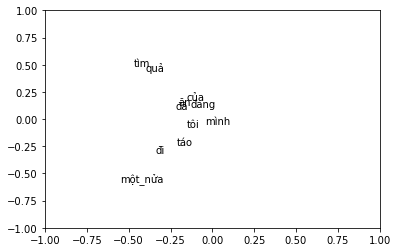

In [3]:
import matplotlib.pyplot as plt
la = np.linalg
U, s, Vh = la.svd(X, full_matrices=False)

plt.xlim(-1, 1)
plt.ylim(-1, 1)

for i in range(len(words)):
    plt.text(U[i, 0], U[i, 1], words[i])

plt.show()

Nhận thấy là từ "tôi" và từ "mình" đã khá gần nhau, chứng tỏ chúng có mối quan hệ sát với nhau. Ma trận đồng xuất hiện đã biểu diễn thành công.

Ưu điểm:
* Đơn giản, dễ cài đặt
* Ghi nhận được thông tin đồng xuất hiện của các từ trong dữ liệu train

Nhược điểm:
* Cần không gian lưu trữ thông tin. Có thể cải thiện bằng phương pháp SVD để giảm chiều dữ liệu, nhưng chi phí tính toán cũng tăng theo và gây khó khăn nếu thêm dữ liệu mới.
* Chưa chi tiết được mức độ tương quan giữa 2 từ bất kỳ.

# 2. Word2Vec

Trong năm 2012, Thomas Mikolov, khi đó là một thực tập sinh tại Microsoft, tìm một phương pháp mã hoá ý nghĩa của từ trong không gian vector nhỏ nhất. Mikolov đã train một mạng neuron để dự đáon từ xung quan gần một từ mục tiêu nào đó. Trong năm 2013, một lần ở Google, Mikolov và team của anh ấy đã phát hành word2vec - một model word embedding học không giám sát (Không cần gán nhãn các từ).

Word2Vec lần đầu được công bố năm 2013 tại hội nghị ACL. Word2Vec embedding chính xác hơn (45%) khoảng 4 lần so với mô hình LSA (11%) với bài toán trả lời câu hỏi tự động. Độ chính xác cải tiến đáng ngạc nhiên đến mức ban đầu, báo cáo của team Mikolov bị loại, vì nfuowfi ta cho rằng hoạt động của mô hình quá tốt đến mức khó tin. Phải mất gần 1 năm cho team của Mikolov để chứng minh và được chấp nhận.

Word2Vec là một mạng neuron với 1 tầng ẩn duy nhất. Thay vì lưu thông tin xuất hiện của các từ bằng cách đếm trực tiếp như ma trận đồng xuất hiện, word2vec học để đoán từ lân cận của tất cả các từ. Mô hình này tính toán nhanh hơn và dễ dàng thêm dữ liệu mới vào mô hình. Nhờ vào tool này mà các bạn có thể train hay sử dụng lại pretrained model word embedding rất đơn giản. 

**Khái niệm windown size:**

Window size được hiểu như một cửa sổ trượt qua mỗi từ, ví dụ windown_size=2 tức là lấy 2 từ bên trái và bên phải mỗi từ trung tâm.

<img src="./images/windown_size.png"/>

Word2Vec có 2 cách để train mô hình là **skip-gram** và **continous bag of words (CBOW)**

## 2.1 Skip-gram

Đối với skip-gram, input là từ mục tiêu, output là các từ xung quanh (có quan hệ gần nhất với các từ đó).

Ví dụ câu: `I have a cute dog`

Input là `a`

Output sẽ là `have`, `cute`, `dog`

Input và output cùng kích thước và được mã hoá one-hot, lớp ẩn có kích thước nhỏ hơn kích thước lớp input và output.

<img src="./images/skipgrammodel.png"/>

Hidden layer là tuyến tính.

Hàm kích hoạt cho lớp output là softmax.

<img src="./images/skipgramclean.png"/>

**Ký hiệu mô hình:**

<img src="./images/sgram.png"/>

$w_i$: Từ thứ i của bộ từ vựng vocabulary $V$

$W \in \mathbb{R}^{V\times N}$ : ma trận word input

$v_i$ : cột thứ $i$ của $W$, là vector biểu diễn cho $w_i$

${{\text{W}}^{'}}\in {{\mathbb{R}}^{N\times V}}$ : ma trận word output

$u_i$: hàng thứ i của ma trận ${{\text{W}}^{'}}$, là vector đại diện cho word $w_i$

**Cách thức hoạt động:**
1. Tạo 1 vector one-hot $x$ là input đầu vào (shape = 1xV) đóng vai trò là từ trung tâm.
2. Lấy được vector nhúng của từ trung tâm ${{x}_{1xV}}{{\text{W}}_{VxN}}={{v}_{1xN}}$. Gọi là $v_c$.  <br/>
<img src="./images/matrix_mult_w_one_hot.png"/><br/>
3. Tạo vector score $z={{v}_{c}}{{\text{W}}^{'}}$, shape=(1,V).
4. Biến vector thành xác suất: $y_{\text{predict}}=\text{softmax(}z\text{)}$

**Hàm mục tiêu:**

<img src="./images/hammuctieuskip.png"/>


**Hàm mất mát:**

<img src="./images/hammatmatskip.png"/>


# 2.2 CBOW

CBOW thì ngược lại có với skip-gram, input là context (ngữ cảnh), output là từ gần nhất với context đó.

<img src="./images/cbowmodel.png"/>

**Ký hiệu mô hình:**

<img src="./images/CBOW.png"/>


$w_i$: Từ thứ i của bộ từ vựng vocabulary $V$

$W \in \mathbb{R}^{V\times N}$ : ma trận word input

$v_i$ : cột thứ $i$ của $W$, là vector biểu diễn cho $w_i$

${{\text{W}}^{'}}\in {{\mathbb{R}}^{N\times V}}$ : ma trận word output

$u_i$: hàng thứ i của ma trận ${{\text{W}}^{'}}$, là vector đại diện cho word $w_i$

**Cách thức hoạt động:**
1. Tạo ra các vecor one-hot cho input context: ${{x}^{(c-m)}},...,{{x}^{(c-1)}},{{x}^{(c+1)}},...,{{x}^{(c+m)}}\in {{\mathbb{R}}^{|V|}}$, shape=(1, V)

2. Lấy được các vector từ nhúng cho các từ ngữ cảnh: $v_{c-m}= x^{(c-m)}W$,...,$v_{c+m}= x^{(c+m)}W$, shape=(1, N)

3. Tính trung bình các vector nhúng: $\overline{v}=\frac{{{v}_{c-m}}+...+{{v}_{c+m}}}{2m}$

4. Tính vector score: $z=\overline{v}{\text{W}}^{'}$ , shape = (1, V)

5. Biến các score thành xác xuất $y_\text{predict} = \text{softmax}(z)$

<img src="./images/muctieu_matmat_CBOW.png"/>

# 3. Thực hành sử dụng word2vec của packet gensim để xây dựng model

Thiết lập hàm đọc dữ liệu <br/>
Chúng ta sẽ đọc dữ liệu từ file truyện tiểu thuyết `Tôi ghét anh, đồ cu côn` của web Teencity.Xtgem.Com


In [4]:
import pandas as pd
import re
from nltk import ngrams
from gensim.models import Word2Vec

pd.options.display.max_rows = 50

In [5]:
df = pd.read_csv("./toi-ghet-anh-do-du-con.txt",sep="\n", names=["row"], encoding="utf8").dropna()
df.head(10)

,row
0,[ten]Tôi ghét anh...Đồ du côn[/ten]
1,[info]
2,[img]http://teencity.xtgem.us/teencity/img/toi...
3,Tôi tên Nhiên - Tôn Nữ Hà Nhiên vs số điểm đỗ ...
4,* học là con đường duy nhất dẫn đến 1 tương la...
5,* ko được để bất cứ chuyện gì ảnh hưởng đến vi...
6,"* phải tránh xa những việc tầm xào ba láp, nhữ..."
7,Lúc còn nhỏ tôi thường hay thắc mắc ko hiểu sa...
8,' ghét của nào trời trao của ấy' các cụ nói cấ...
9,- Dừng lại….


In [6]:
def transform_row(row):
    # Xóa số 
    row = re.sub(r"[0-9\.]+", "", row)
    
    # Xóa dấu chấm, phẩy, hỏi ở cuối câu
    row = re.sub(r"[\.,\?]+", "", row)
    
    # Xóa tất cả dấu chấm, phẩy, chấm phẩy, chấm thang, ... trong câu
    row = row.replace(",", "").replace(".", "") \
        .replace(";", "").replace("“", "") \
        .replace(":", "").replace("”", "") \
        .replace('"', "").replace("'", "") \
        .replace("!", "").replace("?", "") \
        .replace("*","")
    
    row = row.strip()
    return row 

df["row"] = df.row.apply(transform_row)
df.head(10)

,row
0,[ten]Tôi ghét anhĐồ du côn[/ten]
1,[info]
2,[img]http//teencityxtgemus/teencity/img/toi-gh...
3,Tôi tên Nhiên - Tôn Nữ Hà Nhiên vs số điểm đỗ ...
4,học là con đường duy nhất dẫn đến tương lai s...
5,ko được để bất cứ chuyện gì ảnh hưởng đến việc...
6,phải tránh xa những việc tầm xào ba láp những ...
7,Lúc còn nhỏ tôi thường hay thắc mắc ko hiểu sa...
8,ghét của nào trời trao của ấy các cụ nói cấm c...
9,- Dừng lại…


Tách từ sử dụng ngram. Để cho nhanh thay vì sử dụng `tokenize` tiếng Việt, chúng ta sẽ dùng `unigram(1-gram)` và `bigram(2-gram)` để tách từ ra.
Với các bigram không có nghĩa, các từ này sẽ xuất hiện ít hơn `n` lần sẽ bị loại bỏ bằng tham số `min_count` của Word2Vec.

In [7]:
def kieu_ngram(string, n=1):
    try:
        gram_str = list(ngrams(string.strip().split(), n))
        return [ " ".join(gram).lower() for gram in gram_str]
    except:
        print(string)
        return []

df["1gram"] = df.row.apply(lambda t: kieu_ngram(t, 1))
df["2gram"] = df.row.apply(lambda t: kieu_ngram(t, 2))

In [8]:
df.head(7)

,row,1gram,2gram
0,[ten]Tôi ghét anhĐồ du côn[/ten],"[[ten]tôi, ghét, anhđồ, du, côn[/ten]]","[[ten]tôi ghét, ghét anhđồ, anhđồ du, du côn[/..."
1,[info],[[info]],[]
2,[img]http//teencityxtgemus/teencity/img/toi-gh...,[[img]http//teencityxtgemus/teencity/img/toi-g...,[]
3,Tôi tên Nhiên - Tôn Nữ Hà Nhiên vs số điểm đỗ ...,"[tôi, tên, nhiên, -, tôn, nữ, hà, nhiên, vs, s...","[tôi tên, tên nhiên, nhiên -, - tôn, tôn nữ, n..."
4,học là con đường duy nhất dẫn đến tương lai s...,"[học, là, con, đường, duy, nhất, dẫn, đến, tươ...","[học là, là con, con đường, đường duy, duy nhấ..."
5,ko được để bất cứ chuyện gì ảnh hưởng đến việc...,"[ko, được, để, bất, cứ, chuyện, gì, ảnh, hưởng...","[ko được, được để, để bất, bất cứ, cứ chuyện, ..."
6,phải tránh xa những việc tầm xào ba láp những ...,"[phải, tránh, xa, những, việc, tầm, xào, ba, l...","[phải tránh, tránh xa, xa những, những việc, v..."


In [9]:
df["context"] = df["1gram"] + df["2gram"]
df.head(7)

,row,1gram,2gram,context
0,[ten]Tôi ghét anhĐồ du côn[/ten],"[[ten]tôi, ghét, anhđồ, du, côn[/ten]]","[[ten]tôi ghét, ghét anhđồ, anhđồ du, du côn[/...","[[ten]tôi, ghét, anhđồ, du, côn[/ten], [ten]tô..."
1,[info],[[info]],[],[[info]]
2,[img]http//teencityxtgemus/teencity/img/toi-gh...,[[img]http//teencityxtgemus/teencity/img/toi-g...,[],[[img]http//teencityxtgemus/teencity/img/toi-g...
3,Tôi tên Nhiên - Tôn Nữ Hà Nhiên vs số điểm đỗ ...,"[tôi, tên, nhiên, -, tôn, nữ, hà, nhiên, vs, s...","[tôi tên, tên nhiên, nhiên -, - tôn, tôn nữ, n...","[tôi, tên, nhiên, -, tôn, nữ, hà, nhiên, vs, s..."
4,học là con đường duy nhất dẫn đến tương lai s...,"[học, là, con, đường, duy, nhất, dẫn, đến, tươ...","[học là, là con, con đường, đường duy, duy nhấ...","[học, là, con, đường, duy, nhất, dẫn, đến, tươ..."
5,ko được để bất cứ chuyện gì ảnh hưởng đến việc...,"[ko, được, để, bất, cứ, chuyện, gì, ảnh, hưởng...","[ko được, được để, để bất, bất cứ, cứ chuyện, ...","[ko, được, để, bất, cứ, chuyện, gì, ảnh, hưởng..."
6,phải tránh xa những việc tầm xào ba láp những ...,"[phải, tránh, xa, những, việc, tầm, xào, ba, l...","[phải tránh, tránh xa, xa những, những việc, v...","[phải, tránh, xa, những, việc, tầm, xào, ba, l..."


In [10]:
train_data = df.context.tolist()

Train_Data lúc này sẽ là 1 list chứa các `1-gram` và `2-gram`. Chúng ta sử dụng model Word2Vec sẵn có của gensim để build.

In [11]:
# train model with gensim
num_features = 300 # số phần tử vector từ để biểu diễn từ
min_word_count = 3 # số min cho phép trong mô hình W2V
num_workers = 2 # số nhân CPU sử dụng để train
window_size = 6 # cửa số từ , ngữ cảnh
subsampling = 1e-3 # tỷ lệ mẫu con 

model = Word2Vec(
    train_data,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=window_size,
    sample=subsampling)

In [12]:
# Số từ vựng trong model
len(model.wv.vocab)

8710

In [30]:
# Xem những từ có quan hệ gần với từ du con
model.wv.similar_by_word("du côn")

[('anh chàng', 0.9999722242355347),
 ('lúc ấy', 0.999966025352478),
 ('cuối cùng', 0.9999651908874512),
 ('xuất hiện', 0.9999611377716064),
 ('nước mắt', 0.9999601244926453),
 ('thần đồng', 0.9999585747718811),
 ('xin lỗi', 0.9999579191207886),
 ('của trường', 0.9999567270278931),
 ('chỉ tại', 0.999956488609314),
 ('tôi chưa', 0.9999563694000244)]

Kết quả có vẻ ra đúng, câu chuyện này nói về một tình yêu, du côn trong câu chuyện này ám chỉ một `anh chàng `, và anh này học rất giỏi trong trường, tức là ` thần đồng `, ` của trường `. vân vân.. để chi tiết hơn thì bạn có thể đọc truyện và thấy những từ kia có liên quan. Tất nhiên với bộ dữ liệu của chúng ta là quá nhỏ, chỉ là một tiểu thuyết, trong thực tế, để mô hình hoạt động tốt và tổng quát, thường phải train với dữ liệu rất lớn. Người ta hay dùng mô hình này dưới dạng pretrained, tức là file đã train và load model để sử dụng luôn.

Để **lưu model** chúng ta làm như sau:

In [31]:
model_name = "toi_ghet_anh_do_du_con_word2vec_model"
model.save(model_name)

Để load model và sử dụng lại chúng ta làm như sau:

In [42]:
# Test model
from gensim.models.word2vec import Word2Vec
model_name = "toi_ghet_anh_do_du_con_word2vec_model"
model = Word2Vec.load(model_name)

In [70]:
model.wv.most_similar('đẹp trai')

[('con trang', 0.9999856352806091),
 ('thế mà', 0.9999839067459106),
 ('cái gì', 0.9999822974205017),
 ('gì cả', 0.9999814629554749),
 ('như tôi', 0.9999805688858032),
 ('bao h', 0.9999803304672241),
 ('con nhỏ', 0.9999783039093018),
 ('chuyện gì', 0.9999783039093018),
 ('đưa tay', 0.9999780058860779),
 ('nữa chứ', 0.9999765157699585)]

Chúng ta sẽ thử giảm chiều dữ liệu bằng PCA để hiện thị mối quan hệ các từ lên không gian 2 chiều.

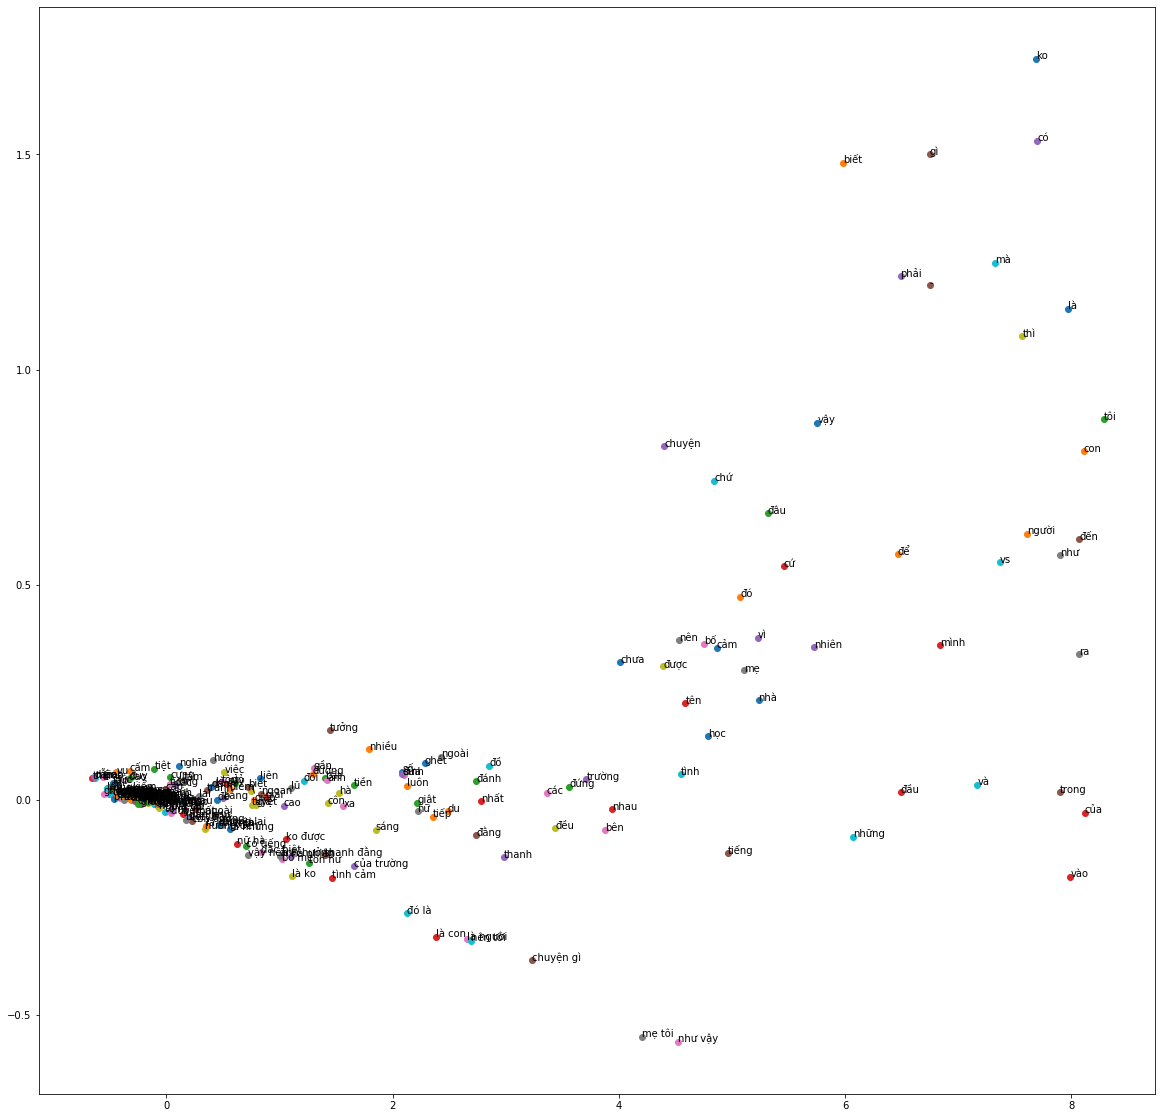

In [32]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
words_np = []
words_label = []
for word in model.wv.vocab.keys():
    words_np.append(model.wv[word])
    words_label.append(word)

pca = PCA(n_components=2)
pca.fit(words_np)
reduced = pca.transform(words_np)
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,20)
for index,vec in enumerate(reduced):
    if index <200:
        x,y=vec[0],vec[1]
        plt.scatter(x,y)
        plt.annotate(words_label[index],xy=(x,y))
plt.show()


**Ưu điểm:**
-	Word2Vec thực sự chính xác khi bộ copus thật lớn và tiền xử lý chuẩn. Các ví dụ bên trên chỉ mang tính chất thử nghiệm nên dữ liệu còn nhỏ và chưa xử lý chuẩn hoàn toàn. Word2Vec đã khắc phục được nhược điểm của ma trận đồng xuất hiện và bag of word.
-	Người ta cho rằng Skip-gram có xu hướng làm tốt hơn với những từ hiếm. Tuy nhiên, hiệu suất của Skip-Gram và Cbow thường ngang nhau.

**Nhược điểm:**
-	Word2vec không biểu thị được những từ không có trong tập huấn luyện. 
-	Mạng Neural lớn, nếu chạy gradien descent sẽ rất chậm.

**Cải tiến:**

Có 3 cải tiến cơ bản cho mô hình word2vec truyền thống:<br/>
-	Xử lý các cặp từ thông dụng hoặc cụm từ như là một từ đơn: Ví dụ các từ như “thành_phố_Cảng” có nghĩa khác nhau với từng từ “thành_phố” và “cảng”<br/>
-	Loại bỏ các từ thường xuyên lặp lại để giảm số lượng các ví dụ huấn luyện : Các từ thường xuyên lặp lại như “các”, “những”,<br/>
-	Sửa đổi mục tiêu tối ưu hóa bằng một kỹ thuật gọi là “Negative Sampling”: Mỗi mẫu huấn luyện chỉ thay đổi một tỷ lệ phần trăm nhỏ các trọng số, thay vì tất cả chúng.<br/>


Tìm hiểu thêm về pretraied word2vec tiếng việt: https://github.com/sonvx/word2vecVN

# 4. Glove

**GloVe** là viết tắt của **glo**bal **ve**ctors, một dự án mã nguồn mở của Stanford nhằm tạo ra các véc tơ biểu diễn cho các từ. Sử dụng các véc tơ từ được huấn luyện bởi GloVe, các mô hình có thể tận dụng thông tin về mối quan hệ ngữ nghĩa giữa các từ tốt hơn, từ đó có kết quả tốt hơn trong các bài toán NLP.

Trang chủ của glove: https://nlp.stanford.edu/projects/glove/

Trang chủ của GloVe cung cấp 4 file chứa các vectơ từ được huấn luyện trên các bộ dữ liệu web khác nhau (đều rất đồ sộ). Chúng ta sẽ sử dụng “Wikipedia 2014 + Gigaword 5”, đây là file nhỏ nhất `(“ glove.6B.zip”)` có dung lượng `822 MB`. Nó được huấn luyện trên một kho ngữ liệu chứa 6 tỷ từ trong tập từ vựng chứa 400 nghìn từ khác nhau.

Sau khi tải và giải nén, chúng ta có 4 file txt: `glove.6B.50d.txt`, `glove.6B.100d.txt`, `glove.6B.200d.txt`, `glove.6B.300d.txt`. *50d*, *100d*, *200d* và *300d* biểu diễn số chiều (dimension) của véc tơ từ. Trong bài này, chúng ta sẽ sử dụng véc tơ có chiều 50 `(glove.6B.50d.txt)`. Để nạp các véc tơ từ GloVe, chúng ta thực hiện như sau:

In [34]:
import numpy as np
words = []
idx = 0
word2idx = {}
vectors = []
with open("./glove.6B.50d.txt","rb") as f:
    for l in f:
        line = l.decode().split()
        word = line[0]
        words.append(word)
        word2idx[word] = idx
        idx += 1
        vect = np.array(line[1:]).astype(np.float)
        vectors.append(vect)
glove = {w:vectors[word2idx[w]] for w in words}

Như vậy chúng ta đã nạp thành công véc tơ của GloVe, chúng ta in vector biểu diễn cho từ `“the”` và nhận được kết quả như sau:

In [35]:
glove["the"]

array([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
       -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
        2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
        1.1658e-02,  1.0204e-01, -1.2792e-01, -8.4430e-01, -1.2181e-01,
       -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01,
       -1.8823e+00, -7.6746e-01,  9.9051e-02, -4.2125e-01, -1.9526e-01,
        4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,
        7.4449e-03,  1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02,
       -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
        1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01])

các véc tơ từ có thể biểu diễn mức độ tương đồng về ý nghĩa giữa các từ. Để kiểm chứng điều đó, ta sử dụng hàm cosine similarity đã giới thiệu ở các bài trước. Đoạn code dưới đây sử dụng Cú pháp giản lược trong Python.

In [36]:
cos_sim = lambda a,b: np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))

chúng ta sẽ đo độ tương đồng giữa các từ: `table`, `chair`, `dog` và `cat`

In [37]:
cos_sim(glove['dog'], glove['cat'])

0.9218005273769252

In [38]:
cos_sim(glove['table'], glove['chair'])

0.5915805854022259

In [40]:
cos_sim(glove['dog'], glove['table'])

0.3796810258522838

Như vậy chúng ta có thể thấy, độ gần gũi về mặt ngữ nghĩa giữa “dog” và “cat”, “table” và “chair” cao hơn giữa “dog” và “table”.

# 5. Fasttext

Như đã đề cập, word2vec có một nhược điểm rất lớn đó là không biểu thị được những từ không có trong tập huấn luyện. Để khắc phục điều này, chúng ta có FastText là mở rộng của Word2vec, được xây dựng bởi Facebook năm 2016. 

**Ý tưởng:**

Thay vì training n-gram cho đơn vị word, Fasttext chia text ra làm nhiều đoạn nhỏ được gọi là n-gram cho ký tự. Ví dụ từ apple sẽ thành app, ppl và ple, vector của apple sẽ bằng tổng tất cả các vecto của các n-gram ký tự của nó. Do vậy, nó xử lý rất tốt cho những từ hiếm gặp.

**Thực hành:**

Chúng ta sẽ thực hành tiếp tục trên dữ liệu đã sử dụng ở phần sử dụng thư viện `gensim` cho word2vec. Trong gensim cũng hỗ trợ mô hình FastText. Với word2vec, với bộ dữ liệu đã sử dụng, từ `ly` không có trong tập train và sẽ báo lỗi nếu ta gọi đến nó.

<img src="./images/error.png"/>

Để sử dụng mô hình Fasttext trong gensim, ta làm như sau:

In [67]:
from gensim.models import FastText
model_fasttext = FastText(size=4, window=3, min_count=1, sentences=train_data)

In [69]:
model_fasttext.wv.similar_by_word("ly")

[('(dĩ', 0.9972333312034607),
 ('gỡ', 0.9853051900863647),
 ('(nv', 0.9809396862983704),
 ('bõ', 0.9777457118034363),
 ('ỉu', 0.975545346736908),
 ('bờ', 0.9754458069801331),
 ('lẹ', 0.9728058576583862),
 ('xệ', 0.9698982834815979),
 ('nè)', 0.9696400761604309),
 ('_', 0.9641013145446777)]

**Ưu điểm:**
-	Khắc phục nhược điểm lớn nhất của word2vec là không biểu diễn được từ không có trong tập huấn luyện.

**Nhược điểm:**
-	Đào tạo theo mô hình FastText mất nhiều thời gian hơn (số lượng n-gram lớn hơn nhiều so với số từ). Tuy nhiên nó hoạt động tốt hơn word2vec và cho phép các từ hiếm gặp được trình bày một cách thích hợp.

# 6. Doc2Vec

Trong bài báo `Distributed Representations of Sentences and Document `(http://proceedings.mlr.press/v32/le14.pdf) của Quốc Lê và Mikolov năm 2015, các tác giả đã giới thiệu một phương pháp mới có khả năng tìm vector biểu diễn tốt hơn cho các câu văn/đoạn văn thông qua một mô hình tương tự word2vec được giới thiệu trước đó cũng bởi Mikolov.

<img src="./images/doc2vec.png"/>

Nhìn vào mô hình, bạn có thể thấy mô hình này chỉ khác mô hình word2vec một điểm duy nhất là ngoài input là các ngữ cảnh, chúng ta còn có thêm một giá trị mới là Paragraph. Mô hình sử dụng các vector của câu văn này kết hợp với các vector từ cấu thành lên câu đó để dự đoán từ tiếp theo cho ngữ cảnh. Thông qua quá trình đào tạo như vậy, các vector của câu sẽ có thể lưu trữ thông tin về ngữ cảnh, ý nghĩa của câu, những thông tin mà bản thân ý nghĩa của từng từ trong câu không thể thể hiện được. Nó hoạt động như một bộ nhớ lưu trữ của câu. Cũng chính vì vậy, phương pháp này được gọi là Distributed Memory model (PV-DM).

Cũng như Word2Vec, Doc2Vec cũng có 2 model chính là **DBOW** và **DM**.
- **DBOW** (distributed bag of words): Mô hình này đơn giản là không quan tâm thứ tự các từ, training nhanh hơn, không sử dụng local-context/neighboring. Mô hình chèn thêm một "word" là ParagraphID. ParagraphID này đại diện cho văn bản được training. Sau khi training xong có thể hiểu các vector ParagraphID này là vector embedded của các văn bản.

<img src="./images/DBOW.jpg"/>

- **DM** (distributed memory): xem một paragraph là một từ, sau đó nối từ này vào tập các từ trong câu. Trong quá trình training, vector của paragraph và vector từ đều được update.

<img src="./images/DM.jpg"/>

**Tóm lại:** ta xem văn bản như là một từ, docID/paragraphID được biểu diễn dạng 1-hot, được embedded vào không gian vector.

**Thực hành:** Chúng ta sử dụng gensim để build Doc2Vec:

In [71]:
import multiprocessing
num_cores = multiprocessing.cpu_count() # số core cpu máy tính
# Mô hình gensim Doc2Vec bao gồm vector word cũng như vector document
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
# simple_preprocess là xử lý bỏ qua ký hiệu và dấu chấm câu ...
from gensim.utils import simple_preprocess

corpus=['thắng đẹp trai đây là văn bản thứ nhất', \
        'đây là văn bản thứ hai của thắng']

training_corpus = []
for i, text in enumerate(corpus):
    # input doc2vec gensim là  object TaggedDocument
    tagged_doc = TaggedDocument(simple_preprocess(text),[i])
    training_corpus.append(tagged_doc)
    
model = Doc2Vec(size=100, min_count=2, workers=num_cores, iter=10)
# trước khi mô hình train, cần phải complie vocabulary
model.build_vocab(training_corpus)
model.train(training_corpus, total_examples=model.corpus_count, epochs=model.iter)

c:\program files\python37\lib\site-packages\gensim\models\doc2vec.py:570: UserWarning: The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.
  warnings.warn("The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.")
c:\program files\python37\lib\site-packages\gensim\models\doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


Sau khi training, chúng ta có được các vector từ và vector văn bản. Tìm similarity của một từ (theo khoảng cách cosine).

In [74]:
model.most_similar('đây')

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('bản', 0.02564198337495327),
 ('là', 0.02521197311580181),
 ('thứ', -0.045802101492881775),
 ('thắng', -0.08075515180826187),
 ('văn', -0.09938586503267288)]

Vector của văn bản thứ nhất của chúng ta:

In [78]:
model.docvecs[0]

array([ 2.2568493e-03,  9.3210052e-04,  3.3087980e-03, -4.5263441e-03,
        4.2507282e-04,  5.4394436e-04, -2.8708375e-03,  3.3961046e-03,
       -1.2784940e-03,  1.8597243e-03,  8.3724648e-04,  4.5096473e-04,
        3.3182912e-03, -2.4315291e-03,  1.9031673e-03,  1.1731599e-03,
        4.7343406e-03,  2.5118522e-03, -2.6075919e-03,  1.4940462e-03,
        2.2388312e-03, -2.3263115e-03,  3.4513237e-04,  2.3890643e-03,
        2.7572860e-03,  3.8538016e-03,  3.7525895e-03, -7.1223947e-04,
       -4.0871260e-04,  1.6142105e-03, -2.2683982e-03,  1.8744587e-03,
        4.6680658e-03,  1.4490859e-03, -1.6990985e-03,  7.3453976e-04,
        3.9756796e-03,  2.2051791e-03,  2.2266730e-04,  1.0837726e-03,
       -2.0195534e-04,  1.7704483e-03,  1.5906746e-03, -1.4135871e-03,
       -4.9906494e-03, -6.6548435e-04, -3.8828668e-03, -1.7918881e-03,
       -1.0591266e-03,  1.8492700e-03, -3.6987038e-03, -3.1262864e-03,
        4.0405798e-03,  9.8607922e-04, -4.2108018e-03, -2.3143960e-03,
      

Bạn cũng có thể suy ra một vector document mới. Doc2Vec đòi hỏi training trước khi suy ra vector mới. Dưới đây, bạn cập nhật vector đã train qua 10 step:

In [79]:
model.infer_vector(simple_preprocess('đây là document thứ 3'), steps=10)

array([ 0.00042273, -0.00212791, -0.00234536, -0.00288724, -0.00067708,
       -0.00261725,  0.00253147, -0.00449194, -0.00318389,  0.00229323,
        0.00328198, -0.00267998,  0.00488255,  0.00119804,  0.00249112,
        0.00026277, -0.00377307, -0.00280915,  0.00016934, -0.00350419,
       -0.00211357, -0.00276206,  0.00062321, -0.00144887, -0.0013088 ,
        0.0019634 ,  0.00147185,  0.0027908 ,  0.00190866, -0.00053225,
       -0.00302875, -0.00373762, -0.0032662 , -0.00081044, -0.00317489,
        0.00251423,  0.00291931, -0.00064837, -0.00090624,  0.00456312,
        0.00444463, -0.00253792,  0.00066835, -0.00307435, -0.00381751,
       -0.00224048,  0.001548  ,  0.00328555, -0.00322006, -0.00149964,
       -0.00284264, -0.0040367 ,  0.0018896 ,  0.00327697,  0.00434652,
        0.00231997,  0.00399489, -0.00292885, -0.00369009,  0.00242991,
       -0.00129411, -0.00115089, -0.00238366, -0.00452808,  0.00392235,
        0.00441561, -0.00352977, -0.00180126, -0.00368502, -0.00

Ngoài những mô hình tôi đã giới thiệu, word embedding các bạn có thể tìm hiểu thêm các mô hình sau: `ELMo, BERT, XLNet, ERNIE, Skip-thoughts, Quick-thoughts, FastSent và Denoising autoencoders, InferSent`. Đây đều là các mô hình mới hơn và phức tạp hơn các mô hình đã giới thiệu bên trên.

Xem thêm: https://topdev.vn/blog/mo-hinh-hoa-cau-van-thanh-vetor-trong-mo-hinh-hoc-may/